# Prepare Predictors from Corpus

This notebook processes the large corpus text file to extract word frequencies and prepare predictor data for analysis. The output will be used by `notebook2_corpus_analysis.ipynb` to compare different frequency measures.

In [1]:
import pandas as pd
import re
from collections import Counter
import os
import numpy as np

# File paths
corpus_file_path = '../output/large_corpus.txt'
output_csv_path = '../output/generated_corpus_with_predictors.csv'

print("Starting corpus processing...")
print(f"Corpus file: {corpus_file_path}")
print(f"Output file: {output_csv_path}")

Starting corpus processing...
Corpus file: ../output/large_corpus.txt
Output file: ../output/generated_corpus_with_predictors.csv


In [2]:
# Check if corpus file exists
if not os.path.exists(corpus_file_path):
    print(f"ERROR: Corpus file not found at {corpus_file_path}")
    print("Please ensure the large_corpus.txt file exists in the output directory.")
else:
    print("✓ Corpus file found")
    
    # Read the corpus
    print("Reading corpus...")
    with open(corpus_file_path, 'r', encoding='utf-8') as f:
        corpus_text = f.read()
    
    print(f"Corpus loaded: {len(corpus_text):,} characters")
    print(f"First 200 characters: {corpus_text[:200]}...")

✓ Corpus file found
Reading corpus...
Corpus loaded: 32,429 characters
First 200 characters: **How to Create a Reliable Backup System for Your Digital Life**

In today’s digital world, our lives are increasingly stored on computers, smartphones, and cloud services. From family photos and impo...


In [3]:
# Text preprocessing and tokenization
print("Tokenizing text...")

# Convert to lowercase and extract words using regex
# This pattern matches sequences of letters and some common contractions
words = re.findall(r"\b[a-z]+(?:'[a-z]+)?\b", corpus_text.lower())

print(f"Total tokens extracted: {len(words):,}")
print(f"Sample tokens: {words[:20]}")

# Count word frequencies
print("Counting word frequencies...")
word_counts = Counter(words)
total_words = len(words)
unique_words = len(word_counts)

print(f"Unique words: {unique_words:,}")
print(f"Most common words: {word_counts.most_common(10)}")

Tokenizing text...
Total tokens extracted: 5,296
Sample tokens: ['how', 'to', 'create', 'a', 'reliable', 'backup', 'system', 'for', 'your', 'digital', 'life', 'in', 'today', 's', 'digital', 'world', 'our', 'lives', 'are', 'increasingly']
Counting word frequencies...
Unique words: 1,957
Most common words: [('the', 328), ('a', 239), ('of', 129), ('it', 112), ('in', 99), ('and', 98), ('to', 77), ('s', 59), ('that', 51), ('with', 50)]


In [4]:
# Create DataFrame with word frequency data
print("Creating DataFrame...")

# Convert word counts to DataFrame
df_words = pd.DataFrame([
    {
        'word': word,
        'frequency': count,
        'log_frequency': np.log10(count),
        'relative_frequency': count / total_words,
        'word_length': len(word)
    }
    for word, count in word_counts.items()
])

# Sort by frequency (descending)
df_words = df_words.sort_values('frequency', ascending=False).reset_index(drop=True)

# Add rank
df_words['frequency_rank'] = range(1, len(df_words) + 1)

print(f"DataFrame created with {len(df_words)} rows")
print("\nFirst 10 rows:")
print(df_words.head(10))

Creating DataFrame...
DataFrame created with 1957 rows

First 10 rows:
   word  frequency  log_frequency  relative_frequency  word_length  \
0   the        328       2.515874            0.061934            3   
1     a        239       2.378398            0.045128            1   
2    of        129       2.110590            0.024358            2   
3    it        112       2.049218            0.021148            2   
4    in         99       1.995635            0.018693            2   
5   and         98       1.991226            0.018505            3   
6    to         77       1.886491            0.014539            2   
7     s         59       1.770852            0.011140            1   
8  that         51       1.707570            0.009630            4   
9  with         50       1.698970            0.009441            4   

   frequency_rank  
0               1  
1               2  
2               3  
3               4  
4               5  
5               6  
6               7 

In [5]:
# Data quality checks and filtering
print("Applying data quality filters...")

# Filter out very short words (less than 2 characters) and very long words (more than 20 characters)
# This helps remove noise and focus on meaningful words
original_count = len(df_words)
df_words = df_words[(df_words['word_length'] >= 2) & (df_words['word_length'] <= 20)]
filtered_count = len(df_words)

print(f"Filtered from {original_count:,} to {filtered_count:,} words")
print(f"Removed {original_count - filtered_count:,} words due to length constraints")

# Filter out words that appear only once (hapax legomena) as they're often noise
df_words = df_words[df_words['frequency'] > 1]
final_count = len(df_words)

print(f"After removing hapax legomena: {final_count:,} words")
print(f"Removed {filtered_count - final_count:,} words that appeared only once")

print("\nFinal dataset statistics:")
print(f"Word frequency range: {df_words['frequency'].min()} - {df_words['frequency'].max()}")
print(f"Word length range: {df_words['word_length'].min()} - {df_words['word_length'].max()}")
print(f"Most frequent words: {df_words.head(5)['word'].tolist()}")

Applying data quality filters...
Filtered from 1,957 to 1,951 words
Removed 6 words due to length constraints
After removing hapax legomena: 662 words
Removed 1,289 words that appeared only once

Final dataset statistics:
Word frequency range: 2 - 328
Word length range: 2 - 13
Most frequent words: ['the', 'of', 'it', 'in', 'and']


In [6]:
# Save the processed data to CSV
print("Saving data to CSV...")

# Ensure output directory exists
os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)

# Save to CSV
df_words.to_csv(output_csv_path, index=False)

print(f"✓ Data saved to: {output_csv_path}")
print(f"✓ Ready for analysis in notebook2_corpus_analysis.ipynb")

# Display summary information
print(f"\nSUMMARY:")
print(f"- Processed corpus: {len(corpus_text):,} characters")
print(f"- Total tokens: {total_words:,}")
print(f"- Unique words (after filtering): {len(df_words):,}")
print(f"- Output file: {output_csv_path}")
print(f"- Columns: {list(df_words.columns)}")

# Show a sample of the final data
print(f"\nSample of final data:")
print(df_words.head(15))

Saving data to CSV...
✓ Data saved to: ../output/generated_corpus_with_predictors.csv
✓ Ready for analysis in notebook2_corpus_analysis.ipynb

SUMMARY:
- Processed corpus: 32,429 characters
- Total tokens: 5,296
- Unique words (after filtering): 662
- Output file: ../output/generated_corpus_with_predictors.csv
- Columns: ['word', 'frequency', 'log_frequency', 'relative_frequency', 'word_length', 'frequency_rank']

Sample of final data:
    word  frequency  log_frequency  relative_frequency  word_length  \
0    the        328       2.515874            0.061934            3   
2     of        129       2.110590            0.024358            2   
3     it        112       2.049218            0.021148            2   
4     in         99       1.995635            0.018693            2   
5    and         98       1.991226            0.018505            3   
6     to         77       1.886491            0.014539            2   
8   that         51       1.707570            0.009630         

Creating basic frequency distribution plots...


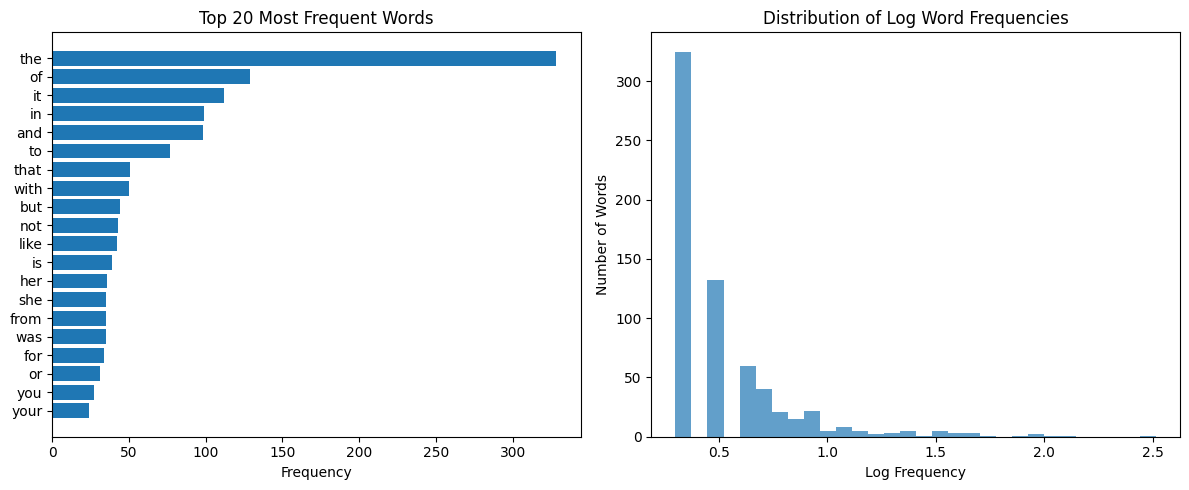

✓ Visualizations created


In [7]:
# Optional: Create basic visualizations
try:
    import matplotlib.pyplot as plt
    
    print("Creating basic frequency distribution plots...")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot 1: Top 20 words
    top_20 = df_words.head(20)
    ax1.barh(range(len(top_20)), top_20['frequency'])
    ax1.set_yticks(range(len(top_20)))
    ax1.set_yticklabels(top_20['word'])
    ax1.set_xlabel('Frequency')
    ax1.set_title('Top 20 Most Frequent Words')
    ax1.invert_yaxis()
    
    # Plot 2: Frequency distribution (log scale)
    ax2.hist(df_words['log_frequency'], bins=30, alpha=0.7)
    ax2.set_xlabel('Log Frequency')
    ax2.set_ylabel('Number of Words')
    ax2.set_title('Distribution of Log Word Frequencies')
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Visualizations created")
    
except ImportError:
    print("Matplotlib not available - skipping visualizations")
    print("Install with: pip install matplotlib")